# Data Cleaning

Xander de la Bruere, Jakob Gertsch, Sam Layton, Matt Mella, Wilson Stoddard

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

### Assignment Guidelines

For this assignment, you need to report your initial data exploration. Consider some of the following points as examples. Upload a Notebook with comments describing what you discovered. The emphasis here is not on perfect formatting, but on showing that you have done your due diligence in exploring the data and thinking through the consequences of what you see.

- Before doing any exploration, consider when and how you plan on holding out data for model evaluation. The gold standard is to have totally independent data you have never seen before tucked away so you can evaluate model performance at the end, but there can be many reasons this may not work. Explain your choice. If you do want to hold out the same data every time, consider fixing a random seed when you make the test-train split.
    - Beware that a test set for time-series data is trickier to build than for independent data points.  If you have training data just before and just after the test data point, the correlation between them means the test depends a lot on the training data and hence is a bad test.  At least ensure your test set comes after your training data, and ideally in a separate data-collection session. 
- Print out a few dozen rows of the data. Is there anything you didn't expect to see? What opportunities for data cleaning and feature engineering may be important? Take care of these things.
- Plot a few individual time series and do a similar check. Is there anything unbelievable you see?
- How much data is missing? Is the distribution of missing data likely different from the distribution of non-missing data? How might you do a meaningful imputation (if needed)? Are there variables that should be dropped? Implement some initial solutions.
- Is there any hint that the data you have collected is differently distributed from the actual application of interest? If so, is there a strategy, such as reweighing samples, that might help?
Use a histogram or KDE to visualize the distribution of key variables. Consider log-scaling or other scaling of the axes. How should you think about outliers? Is there a natural scaling for certain variables?
- Use 2D and/or 3D plot scatter plots, histograms, or heat maps to look for important relationships between variables. Consider using significance tests, linear model fits, or correlation matrices to clarify relationships.
- Does what you see change any of your ideas for what models might be appropriate? Among other things, if your models rely on specific assumptions, is there a way you can check if these assumptions actually hold by looking at the data? If you are using linear models, do the relevant plots look linear? Is there some other scaling where the model assumptions might more nearly hold?

### Basic Description of Data

Our dataset comes from consists of over 140 thousand radio transcripts from NPR. The episodes come from a span of 20 years between January 1999 and October 2019. The transcribed text represents over 10 thousand hours of audio. The data is stored in a CSV file and is summarized by the table below.

| Column | Data Type | Description |
| --- | --- | --- |
| `episode` | int | The episode number |
| `episode_order` | int | The line number within each episode. Note that when a different person begins speaking, the row ends and another begins |
| `speaker` | str | The speaker and (usually) their title |
| `utterance` | str | A block of transcribed audio |

### Data Cleaning for Model Evaluation

Out dataset is naturally split into episodes. To evaluate our model, we will leave out a certain percentage of episodes to train the model, then test our model on entire episodes to see how successfully we can identify different speakers. Training on the same episode would fail to provide independent enough data, giving us too much information with the sentence before and after a test sentence.

However, by using separate episodes, we are testing on data that comes from a separate data collection session. This essentially matches the indicated gold standard of data, where we will permanently set aside a test set of episodes to train on. The test data is structured the same way as the training data, which will be ideal for evaluating our models on.

In [4]:
path = os.getcwd()
print(path)
df = pd.read_csv(f'{path}/archive/utterances.csv')
# remove all speakers labeled as _NO_SPEAKER
df = df[df['speaker'] != '_NO_SPEAKER']

/mnt/c/Users/delab/Documents/Repos/new-phone-who-dis


In [5]:
display(df.head(10))

,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra..."
5,57264,14,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's exactly right.
6,57264,15,"NEAL CONAN, host",And so the guy who's in back has an easier tim...
7,57264,16,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. There's a lot of deal making tha...
8,57264,17,"NEAL CONAN, host","We're talking with Loren Mooney, the editor-in..."
9,57264,18,JOHN (Caller),Hello.


Episode: 57264
Speakers: 6


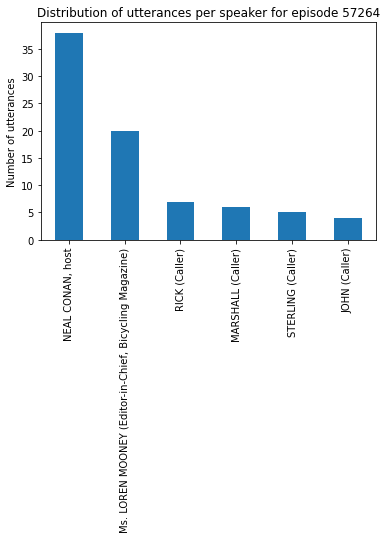

Episode: 58225
Speakers: 8


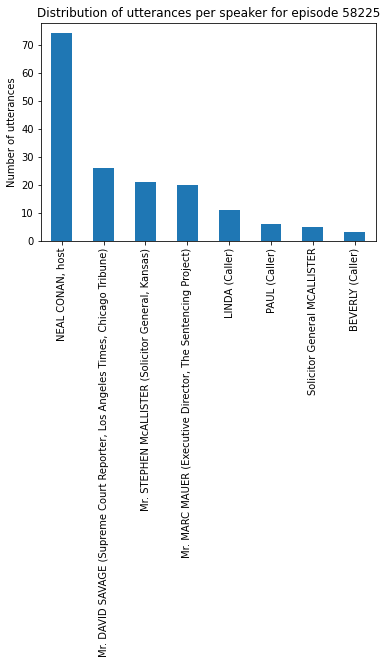

Episode: 75004
Speakers: 4


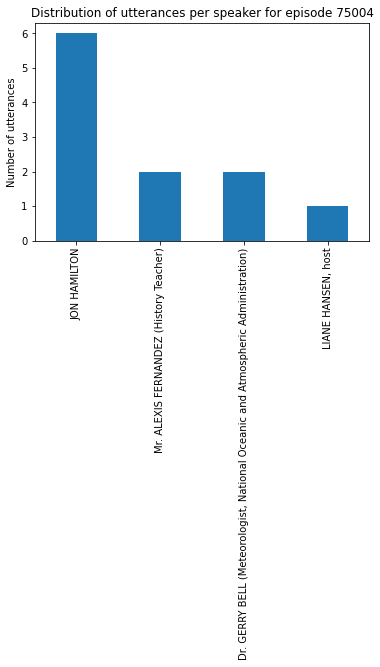

Episode: 74884
Speakers: 2


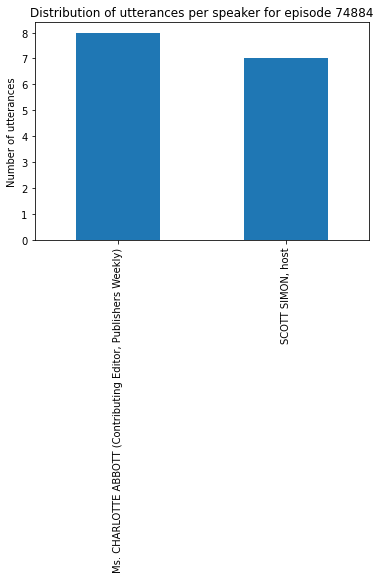

In [6]:
def plot_speaker_distribution_for_episode(df, episode):

    # print the episode
    print('Episode:', episode)

    # Filter the dataframe for the specific episode
    df_episode = df[df['episode'] == episode]

    # print the amount of speakers
    print('Speakers:', len(df_episode['speaker'].unique()))

    # Group by 'speaker' and count the number of rows
    speaker_counts = df_episode['speaker'].value_counts()

    # Plot a bar chart
    speaker_counts.plot(kind='bar')
    plt.ylabel('Number of utterances')
    plt.title(f'Distribution of utterances per speaker for episode {episode}')
    plt.show()

# iterate through the first 10 episodes
for episode in df['episode'].unique()[:4]:
    plot_speaker_distribution_for_episode(df, episode)

### We will find that the distribution of speakers is not equally split. Because many of these conversations are interviews, we will find one speaker overwhelmingly dominates the conversation. Further, outside callers into the show will imply that the members of a conversation vary as callers join and leave the conversation

# OK here's a distribution of number of words per utterance!!!

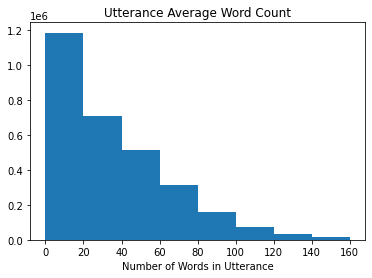

In [7]:
# Redo the index and ensure all utterances are strings, then calculate the word count
df = df.reset_index()
df['utterance'] = df['utterance'].astype(str)
df['word_count']=np.array([len(df['utterance'][i].split()) for i in range(len(df))])

# Plot a histogram showing the relative distribution of word counts across utterances
plt.hist(df['word_count'],bins=[0,20,40,60,80,100,120,140,160])
plt.xlabel("Number of Words in Utterance")
plt.title("Utterance Average Word Count")
plt.show()

In [9]:
df2sp = pd.read_csv('archive/utterances-2sp.csv')

In [10]:
display(df2sp.head(10))

,episode,episode_order,turn_order,speaker_order,host_id,is_host,utterance
0,1,1,0,0,0,True,The impeachment inquiry picks up tomorrow wher...
1,1,1,1,0,0,True,"Just this morning, the lawyer for the whistleb..."
2,1,1,2,0,0,True,There's are a lot of moving parts.
3,1,1,3,0,0,True,"Fortunately, NPR's Mara Liasson is here to help."
4,1,2,0,0,0,True,Good morning.
5,1,3,0,1,-1,False,"Good morning, Lulu."
6,1,4,0,0,0,True,All right.
7,1,4,1,0,0,True,What's the latest?
8,1,5,0,1,-1,False,"Well, the latest is that the lawyer for the fi..."
9,1,5,1,1,-1,False,The first whistleblower only had second and th...


### This is an alternative dataset of just 2-person conversations. This dataset limits what we are modeling to just 2 different speakers, but will avoid the issue of variable participants in a conversation

In [4]:
# remove all speakers labeled as _NO_SPEAKER
df = df[df['speaker'] != '_NO_SPEAKER']
print(len(df))

# group by episode
episodes = df.groupby('episode')

# show the first episode, 57264
display(episodes.get_group(57264))

3015435


,episode,episode_order,speaker,utterance
0,57264,9,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","It's a 2,200-mile race. To give some sense of ..."
1,57264,10,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",So for a top competitor like Lance to try to m...
2,57264,11,"NEAL CONAN, host","So in every team, presumably there's one star,..."
3,57264,12,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",That's right. Each team has nine riders. And w...
4,57264,13,"NEAL CONAN, host","So slipstream, this is like drafting in car ra..."
...,...,...,...,...
3199423,57264,4,"NEAL CONAN, host",Joining us now from our bureau in New York is ...
3199424,57264,5,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...",Thanks for having me.
3199425,57264,6,"NEAL CONAN, host","And I've got my copy of Bicycling Magazine, an..."
3199426,57264,7,"Ms. LOREN MOONEY (Editor-in-Chief, Bicycling M...","Well, yes, it's true. Actually, the race did b..."
